In [89]:
%matplotlib inline

import os

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
from scipy.stats import norm
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, ProbabilityOfImprovement
from scipy import linalg
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import PathToSubmol, FindAtomEnvironmentOfRadiusN, MolToSmiles
from rdkit.Chem.AtomPairs import Pairs
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from map4 import MAP4Calculator
#import tmap as tm


#from mobius import ForceField, VirtualTarget

In [3]:
temperature = 300.
RT = 0.001987 * temperature
RT * np.log(4 * 1e-9)

-11.526768696740188

In [4]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        if last_dim_is_batch:
            # Not tested
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        x1_eq_x2 = torch.equal(x1, x2)
        
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        
        if diag:
            if x1_eq_x2:
                res = torch.ones(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                return res
            else:
                product = torch.mul(x1, x2).sum(dim=1)
                denominator = torch.add(x2s, x1s) - product
        else:
            product = torch.mm(x1, x2.transpose(1, 0))
            denominator = torch.add(x2s, x1s[:, None]) - product

        res = product / denominator
        
        return res

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP, GPyTorchModel):
    # to inform GPyTorchModel API
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoSimilarityKernel())
        # make sure we're on the right device/dtype
        self.to(train_x)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
def get_fitted_model(train_x, train_y, state_dict=None):
    # initialize and fit model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)
    
    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    
    # Train model!
    fit_gpytorch_model(mll)
    
    return model

In [5]:
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


def plot(y_test, observed_pred, fig_filename=None):
    with torch.no_grad():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.scatter(y_test, observed_pred)
        
        ax.set_xlim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_ylim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_xlabel('Experimental values (kcal/mol)', fontsize=20)
        ax.set_ylabel('Predicted values (kcal/mol)', fontsize=20)
        
        if fig_filename is not None:
            plt.savefig(fig_filename, bbox_inches='tight', dpi=300)
        
        plt.show()

In [7]:
def expected_improvement(model, Y_train, Xsamples, greater_is_better=False, xi=0.00):
    """ expected_improvement
    Expected improvement acquisition function.
    
    Source: https://github.com/thuijskens/bayesian-optimization/blob/master/python/gp.py
    
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.
        xi: Exploitation-exploration trade-off parameter

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()

    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum - xi) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + (sigma * norm.pdf(Z))
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


# probability of improvement acquisition function
def probability_of_improvement(model, Y_train, Xsamples, greater_is_better=False):
    """ probability_of_improvement
    Probability of improvement acquisition function.
        
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()
    
    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)
    
    # calculate the probability of improvement
    Z = scaling_factor * (mu - loss_optimum) / (sigma + 1E-9)
    probs = norm.cdf(Z)
    probs[sigma == 0.0] == 0.0
    
    return probs

In [6]:
def map4_fingerprint(sequences, dimensions=4096, radius=2, is_folded=True):
    MAP4_unf = MAP4Calculator(dimensions=dimensions, radius=radius, is_folded=is_folded)
    fps = MAP4_unf.calculate_many([Chem.rdmolfiles.MolFromFASTA(s) for s in sequences])
    return torch.from_numpy(np.array(fps)).float()

## Load dataset

In [2]:
mhci = pd.read_csv('binding_data_2013/bdata.20130222.mhci.csv')

In [3]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
                (~mhci['affinity_binding'].isin(dirty_values))]

In [76]:
decoys = []

with open('uniprot_sprot.fasta') as f:
    lines = f.readlines()
    
    sequence = ''
    
    for line in lines:
        if line.startswith('>'):
            if sequence != '':
                decoys.append((sequence, len(sequence)))
            sequence = ''
        else:
            sequence += line.strip()
        
    decoys.append((sequence, len(sequence)))
    
decoys = pd.DataFrame(data=decoys, columns=('sequence', 'length'))

mhci_decoys = decoys[(decoys['length'] >= 5) & (decoys['length'] <= 20)].copy()
# Remove peptide with unknow amino acids
mhci_decoys = mhci_decoys[~mhci_decoys['sequence'].str.contains('X|Z|B|U', regex=True)]
mhci_decoys['energy'] = 0.

print('Number of decoy peptides: %d' % mhci_decoys.shape[0])

Number of decoy peptides: 3372


## Random train-test (70/30) split (ALL SIZE PEPTIDE)

In [482]:
X_train, X_test, y_train, y_test = train_test_split(mhci['sequence'], mhci['energy'], test_size=0.3)

print(X_train.shape, X_test.shape)

X_train_fps = map4_fingerprint(X_train)
X_test_fps = map4_fingerprint(X_test)

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

(5956,) (2553,)


In [483]:
model = get_fitted_model(X_train_fps, y_train)

R2   : 0.599
RMSD : 1.223 kcal/mol


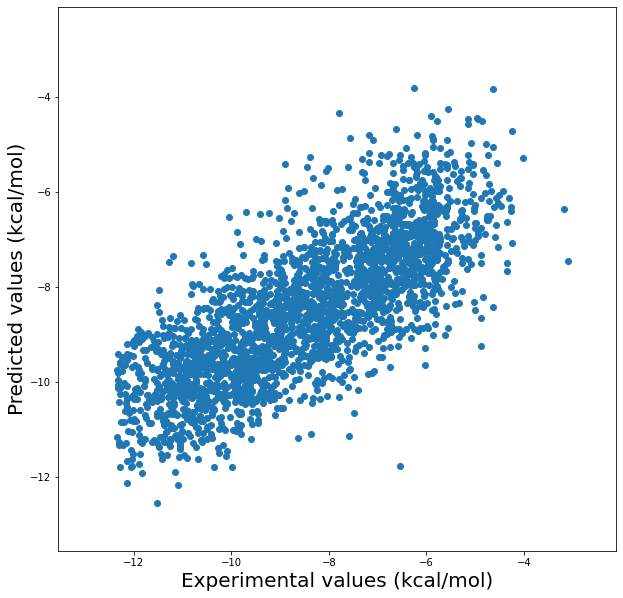

In [485]:
# Predict energy for test set
observed_pred = predict(model, model.likelihood, X_test_fps)
 
print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_MAP4_fps_tanimoto_mhc-i_cleaned_all_size_pep.png')

# Bayesian opt. prototype

In [218]:
# Compute the MAP4 fingerprint for all the peptides
X_fps_exp = map4_fingerprint(mhci['sequence'].values)
y_exp = torch.from_numpy(mhci['energy'].values).float()

print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))

Exp dataset size: (8509, 4096)


In [219]:
# Compute the MAP4 fingerprint for all the DECOY peptides
X_fps_decoys = map4_fingerprint(mhci_decoys['sequence'].values)
y_decoys = torch.from_numpy(mhci_decoys['energy'].values).float()

print('Decoys dataset size: (%d, %d)' % (X_fps_decoys.shape[0], X_fps_decoys.shape[1]))

Decoys dataset size: (3372, 4096)


In [220]:
X_fps = torch.cat([X_fps_exp, X_fps_decoys])
y = torch.cat([y_exp, y_decoys])

print('Full dataset size: (%d, %d)' % (X_fps.shape[0], X_fps.shape[1]))

Full dataset size: (11881, 4096)


In [124]:
fit = umap.UMAP(n_neighbors=100, min_dist=0.1, metric='rogerstanimoto')
u = fit.fit_transform(np.vstack([X_fps.numpy(), X_fps_decoys.numpy()]))

#np.savetxt('umap_embedding_exp_decoys.csv', u, delimiter=',')

/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


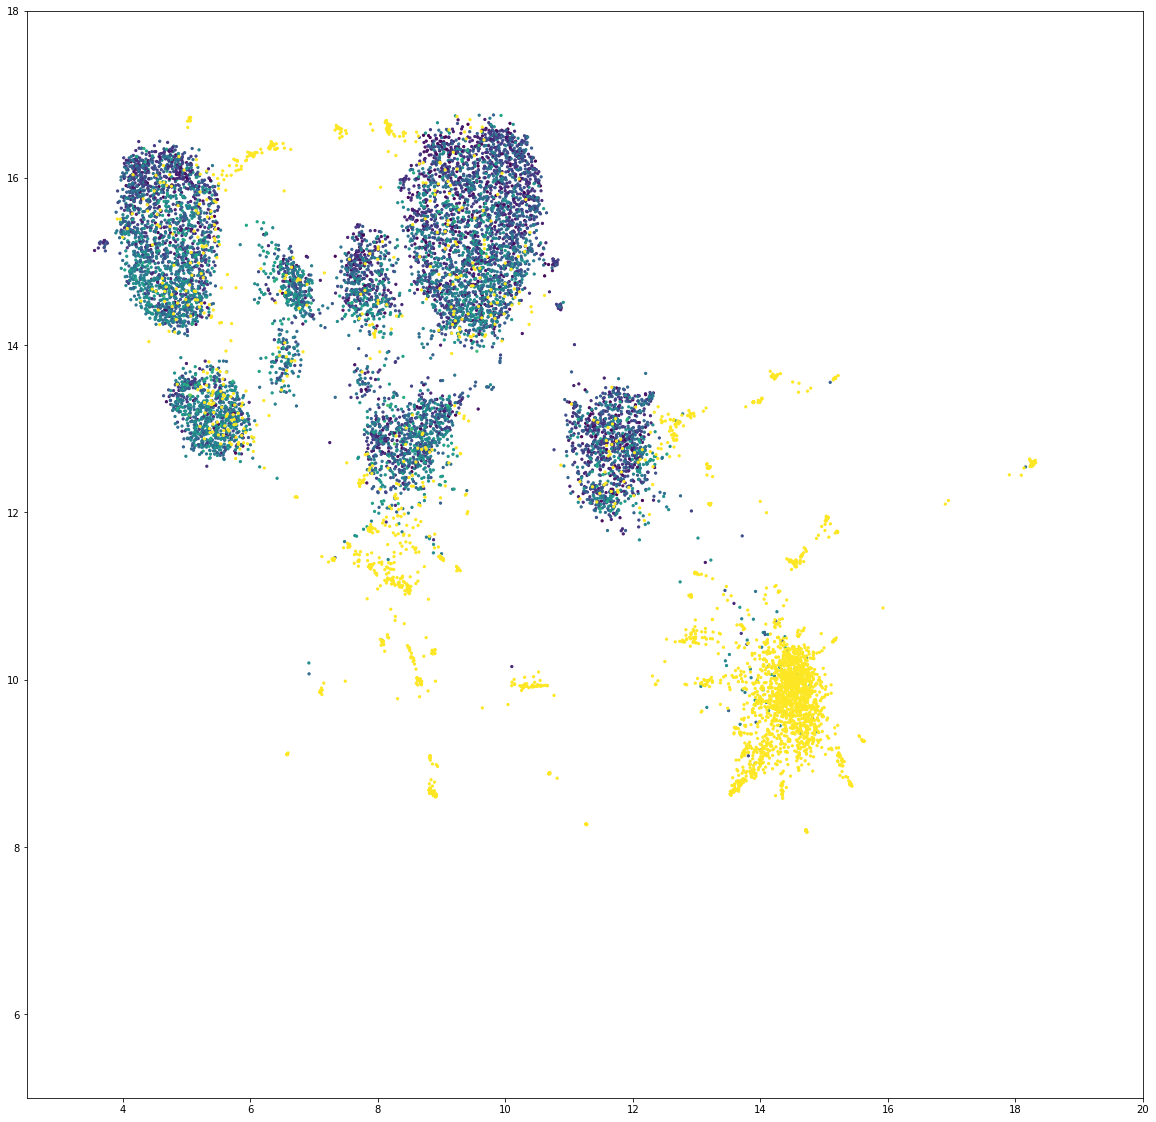

In [232]:
u = np.genfromtxt('umap_embedding_exp_decoys.csv', delimiter=',')

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(u[:,0], u[:,1], s=5, c=y.numpy(), vmin=-12, vmax=0)
ax.set_xlim([2.5, 20])
ax.set_ylim([5, 18])
plt.show()

## ALL + Random low affinity binding peptides

In [225]:
# Select n_training (here 150) low affinity binding peptides (energy > -8.5) for the initial training set
# The other peptides will constitute the peptides pool fro, where we will draw the candidates during the otimization

energy_cutoff = -8.5
n_training = 150

low_affinity_ids = np.where(y_exp.numpy() >= energy_cutoff)[0]
high_affinity_ids = np.where(y_exp.numpy() < energy_cutoff)[0]
decoy_ids = np.arange(len(y_exp), len(y_exp) + len(y_decoys))

print('Low affinity : %d' % low_affinity_ids.shape[0])
print('High affinity: %d' % high_affinity_ids.shape[0])
print('Decoys       : %d' % decoy_ids.shape[0])
print('')

# Training ids
train_ids = np.random.choice(low_affinity_ids, size=n_training, replace=False)

# Pool ids
low_affinity_ids_leftover = low_affinity_ids[~np.in1d(low_affinity_ids, train_ids)]
pool_ids = np.hstack([high_affinity_ids, low_affinity_ids_leftover, decoy_ids])

print('Train: %06d - %.3f %%' % (train_ids.shape[0], train_ids.shape[0] / (mhci.shape[0] + mhci_decoys.shape[0])* 100.))
print('Pool : %06d - %.3f %%' % (pool_ids.shape[0], pool_ids.shape[0] / (mhci.shape[0] + mhci_decoys.shape[0])* 100.))

Low affinity : 4361
High affinity: 4148
Decoys       : 3372

Train: 000150 - 1.263 %
Pool : 011731 - 98.737 %


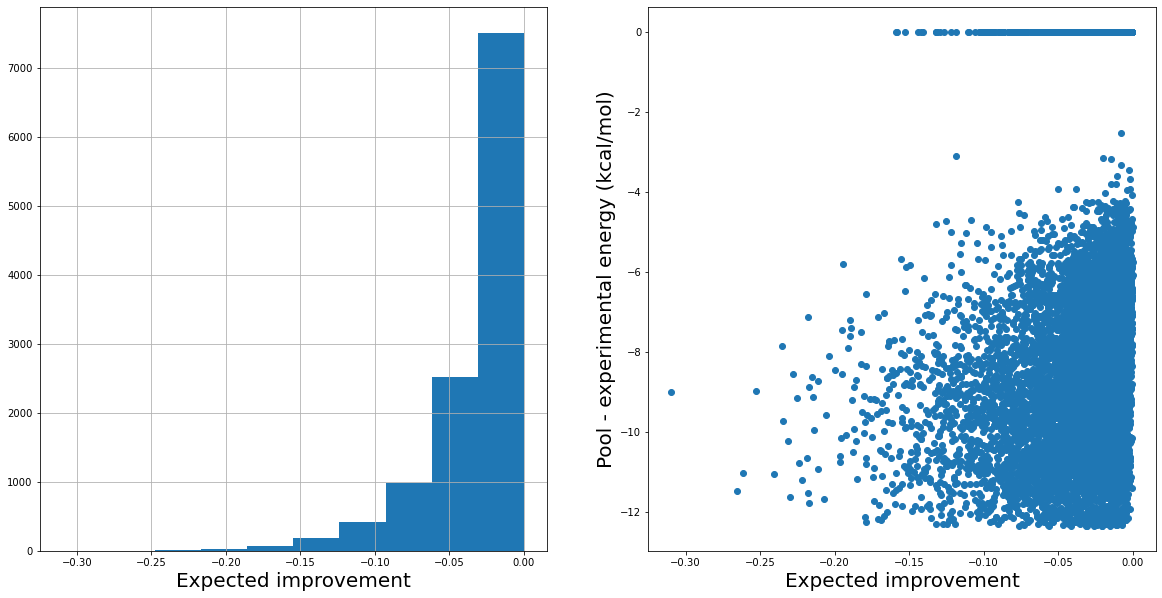

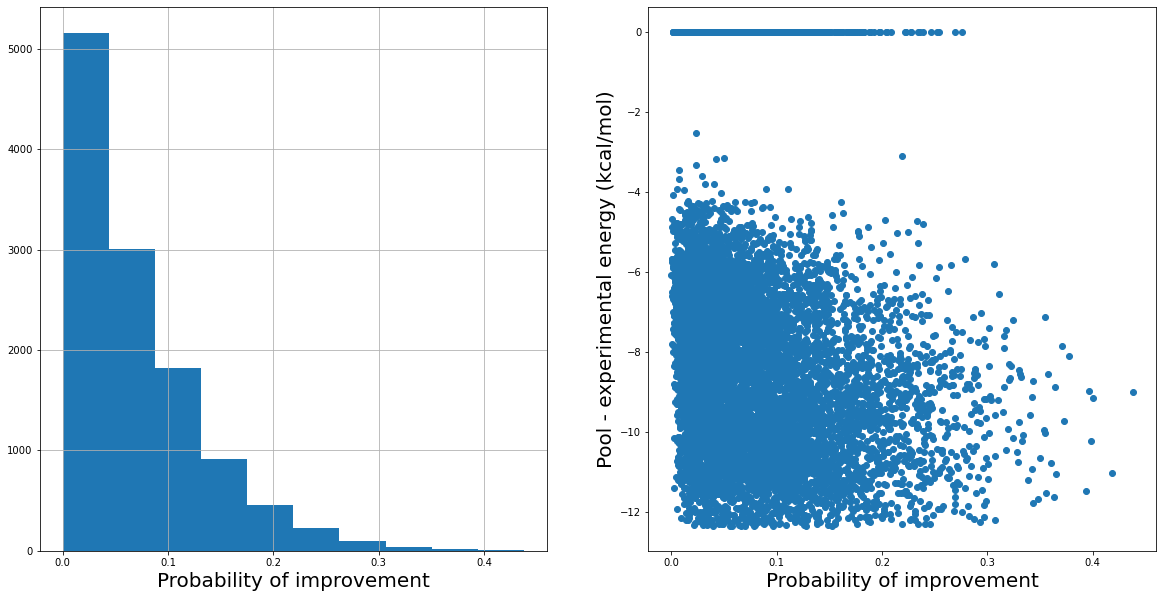

In [226]:
# Show the Expected improvement and Probability of improvement for the initial model

model = get_fitted_model(X_fps[train_ids], y[train_ids])

for ac_fun in ['EI', 'PI']:
    fig, axarr = plt.subplots(1, 2, figsize=(20, 10))
    
    if ac_fun == 'EI':
        p = expected_improvement(model, y[train_ids], X_fps[pool_ids])

        pd.Series(p).hist(ax=axarr[0])
        axarr[0].set_xlabel('Expected improvement', fontsize=20)

        axarr[1].scatter(p, y[pool_ids])
        axarr[1].set_xlabel('Expected improvement', fontsize=20)
    else:
        p = probability_of_improvement(model, y[train_ids], X_fps[pool_ids])

        pd.Series(p).hist(ax=axarr[0])
        axarr[0].set_xlabel('Probability of improvement', fontsize=20)

        axarr[1].scatter(p, y[pool_ids])
        axarr[1].set_xlabel('Probability of improvement', fontsize=20)
    
    axarr[1].set_ylabel('Pool - experimental energy (kcal/mol)', fontsize=20)
    
    plt.show()

Init.
Train:  150
Pool :  11731
Best peptide: -8.458
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
Decoy pep               : 000



1


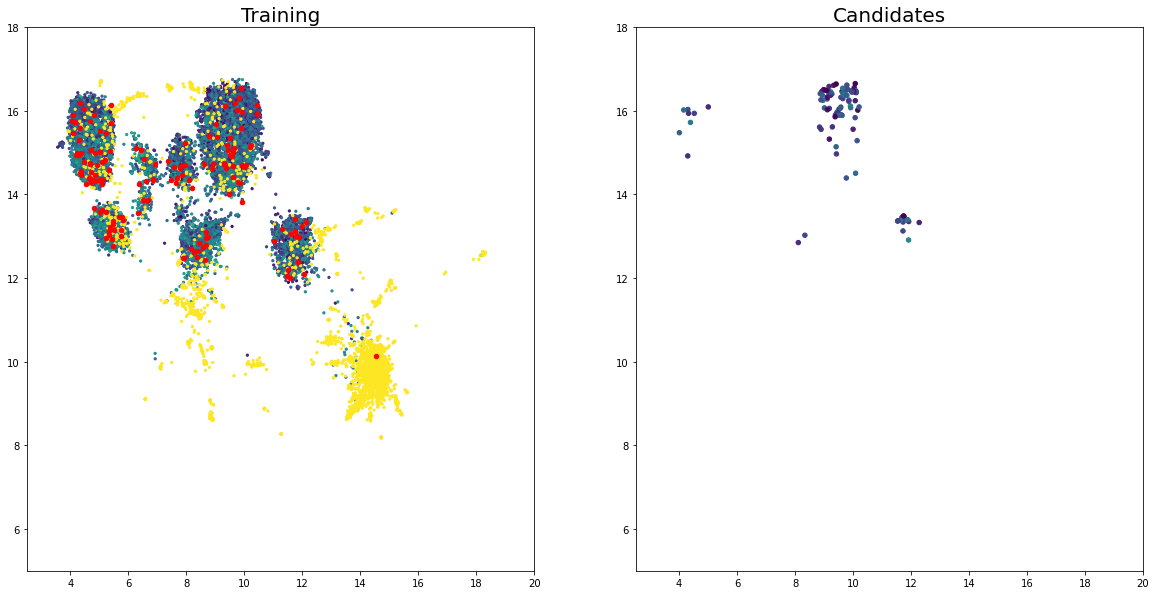

Train:  246
Pool :  11635
Best peptide: -12.232
N pep under -12 kcal/mol: 004 (4.167)
N pep under -11 kcal/mol: 018 (18.750)
N pep under -10 kcal/mol: 038 (39.583)
N pep under -9 kcal/mol: 060 (62.500)
Decoy pep               : 000



2


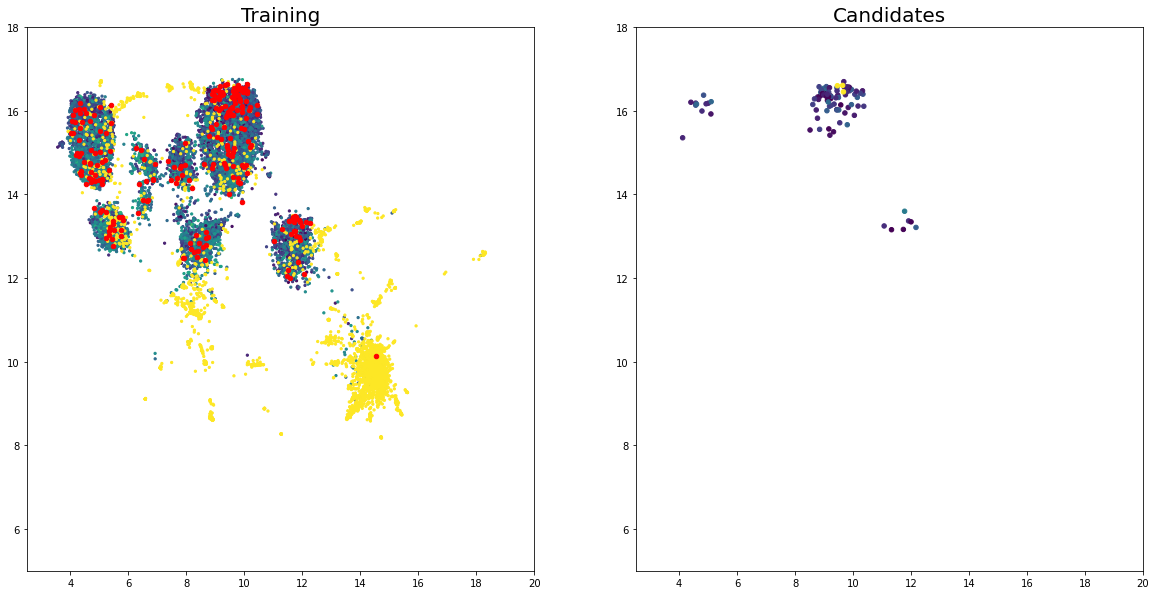

Train:  342
Pool :  11539
Best peptide: -12.292
N pep under -12 kcal/mol: 012 (6.250)
N pep under -11 kcal/mol: 054 (28.125)
N pep under -10 kcal/mol: 097 (50.521)
N pep under -9 kcal/mol: 133 (69.271)
Decoy pep               : 003



3


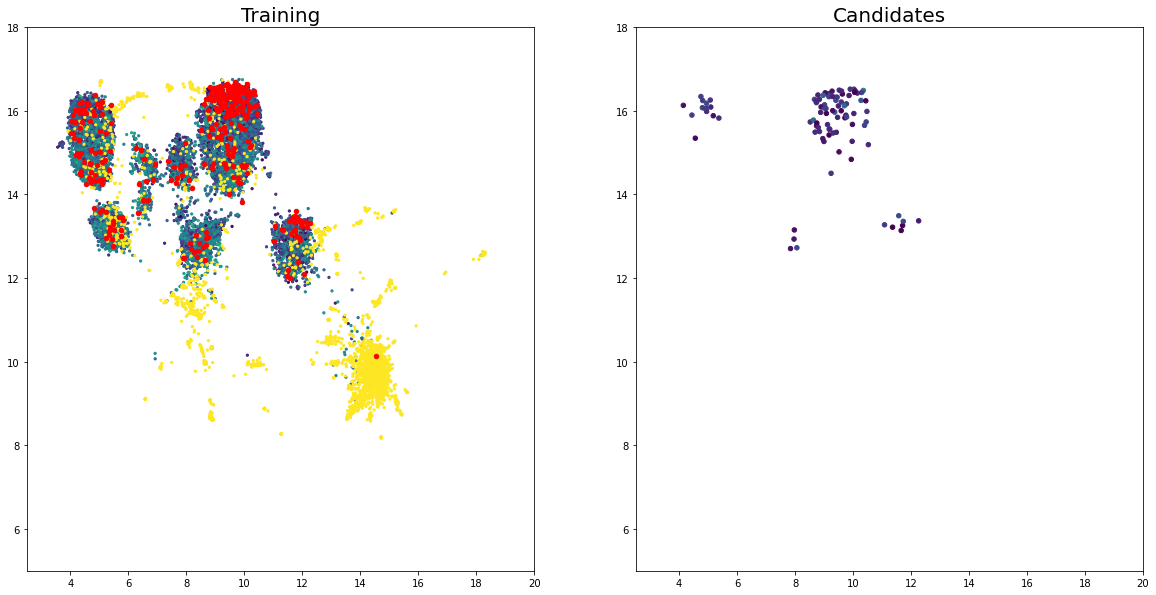

Train:  438
Pool :  11443
Best peptide: -12.336
N pep under -12 kcal/mol: 020 (6.944)
N pep under -11 kcal/mol: 087 (30.208)
N pep under -10 kcal/mol: 164 (56.944)
N pep under -9 kcal/mol: 223 (77.431)
Decoy pep               : 003





In [227]:
n_pep = 96
acq_function = 'PI'

print('Init.')
print('Train: ', X_fps[train_ids].shape[0])
print('Pool : ', X_fps[pool_ids].shape[0])
print('Best peptide: %.3f' % y[train_ids].min())
for n in [-12, -11, -10, -9]:
    print('N pep under %d kcal/mol: %03d' % (n, y[train_ids][y[train_ids] < n].shape[0]))
print('Decoy pep               : %03d' % (y[train_ids][y[train_ids] == 0.].shape[0]))
    
print('\n\n')

for i in range(3):
    print(i + 1)
    model = get_fitted_model(X_fps[train_ids], y[train_ids])
    
    if acq_function == 'EI':
        p = expected_improvement(model, y[train_ids], X_fps[pool_ids], xi=0)
        indices = np.argsort(p)
    else:
        p = probability_of_improvement(model, y[train_ids], X_fps[pool_ids])
        indices = np.argsort(p)[::-1]
    
    # Select candidates
    candidates_ids = pool_ids[indices[:n_pep]]
    
    fig, axarr = plt.subplots(1, 2, figsize=(20, 10))
    axarr[0].scatter(u[:,0], u[:,1], s=5, c=y.numpy(), vmin=-12, vmax=0)
    axarr[0].scatter(u[:,0][train_ids], u[:,1][train_ids], s=20, c='red')
    axarr[1].scatter(u[:,0][candidates_ids], u[:,1][candidates_ids], s=20, c=y.numpy()[candidates_ids], vmin=-12, vmax=0)
    
    axarr[0].set_title('Training', fontsize=20)
    axarr[1].set_title('Candidates', fontsize=20)
    axarr[0].set_xlim([2.5, 20])
    axarr[0].set_ylim([5, 18])
    axarr[1].set_xlim([2.5, 20])
    axarr[1].set_ylim([5, 18])
    
    plt.show()
    
    # Add candidates to train dataset
    train_ids = np.hstack([train_ids, candidates_ids])
    print('Train: ', train_ids.shape[0])
    
    # Remove candidates from pool
    pool_ids = pool_ids[~np.in1d(pool_ids, candidates_ids)]
    print('Pool : ', pool_ids.shape[0])
    print('Best peptide: %.3f' % y[train_ids].min())
    
    for n in [-12, -11, -10, -9]:
        x = y[train_ids][y[train_ids] < n].shape[0]
        print('N pep under %d kcal/mol: %03d (%.3f)' % (n, x, x / (n_pep * (i + 1)) * 100.))
    print('Decoy pep               : %03d' % (y[train_ids][y[train_ids] == 0.].shape[0]))
    
    print('\n\n')

## Region selected + Random low affinity binding peptides

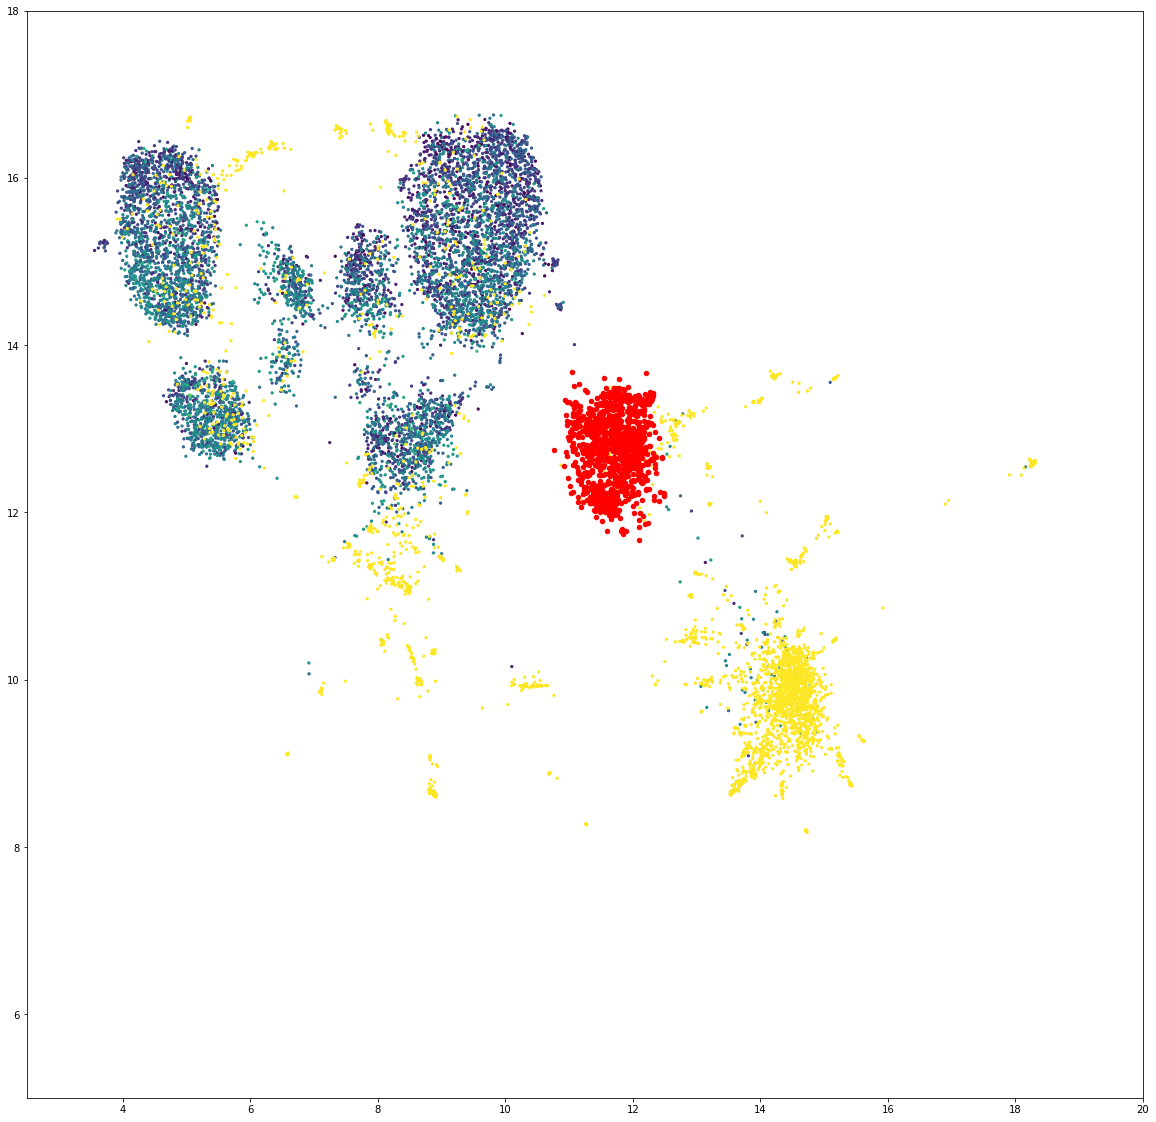

In [278]:
#t = np.hstack(np.argwhere((8.4 < u[:,0]) & (u[:,0] < 10.7) & (14 < u[:,1]) & (u[:,1] < 17)))
#t = np.hstack(np.argwhere((3.8 < u[:,0]) & (u[:,0] < 5.7) & (14 < u[:,1]) & (u[:,1] < 17)))
#t = np.hstack(np.argwhere((4.5 < u[:,0]) & (u[:,0] < 6) & (12 < u[:,1]) & (u[:,1] < 14)))
t = np.hstack(np.argwhere((10.5 < u[:,0]) & (u[:,0] < 12.5) & (11.5 < u[:,1]) & (u[:,1] < 14)))

t = t[t < y_exp.shape[0]]

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(u[:,0], u[:,1], s=5, c=y.numpy(), vmin=-12, vmax=0)
ax.scatter(u[:,0][t], u[:,1][t], s=20, c='red')
ax.set_xlim([2.5, 20])
ax.set_ylim([5, 18])
plt.show()

In [279]:
# Select n_training (here 150) low affinity binding peptides (energy > -8.5) for the initial training set
# The other peptides will constitute the peptides pool fro, where we will draw the candidates during the otimization

energy_cutoff = -8.5
n_training = 150

low_affinity_ids = np.where(y_exp.numpy() >= energy_cutoff)[0]
high_affinity_ids = np.where(y_exp.numpy() < energy_cutoff)[0]
decoy_ids = np.arange(len(y_exp), len(y_exp) + len(y_decoys))

print('Low affinity : %d' % low_affinity_ids.shape[0])
print('High affinity: %d' % high_affinity_ids.shape[0])
print('Decoys       : %d' % decoy_ids.shape[0])
print('')

# Training ids
train_ids = np.random.choice(t, size=n_training, replace=False)

# Pool ids
low_affinity_ids_leftover = low_affinity_ids[~np.in1d(low_affinity_ids, train_ids)]
pool_ids = np.hstack([high_affinity_ids, low_affinity_ids_leftover, decoy_ids])

print('Train: %06d - %.3f %%' % (train_ids.shape[0], train_ids.shape[0] / (mhci.shape[0] + mhci_decoys.shape[0])* 100.))
print('Pool : %06d - %.3f %%' % (pool_ids.shape[0], pool_ids.shape[0] / (mhci.shape[0] + mhci_decoys.shape[0])* 100.))

Low affinity : 4361
High affinity: 4148
Decoys       : 3372

Train: 000150 - 1.263 %
Pool : 011820 - 99.487 %


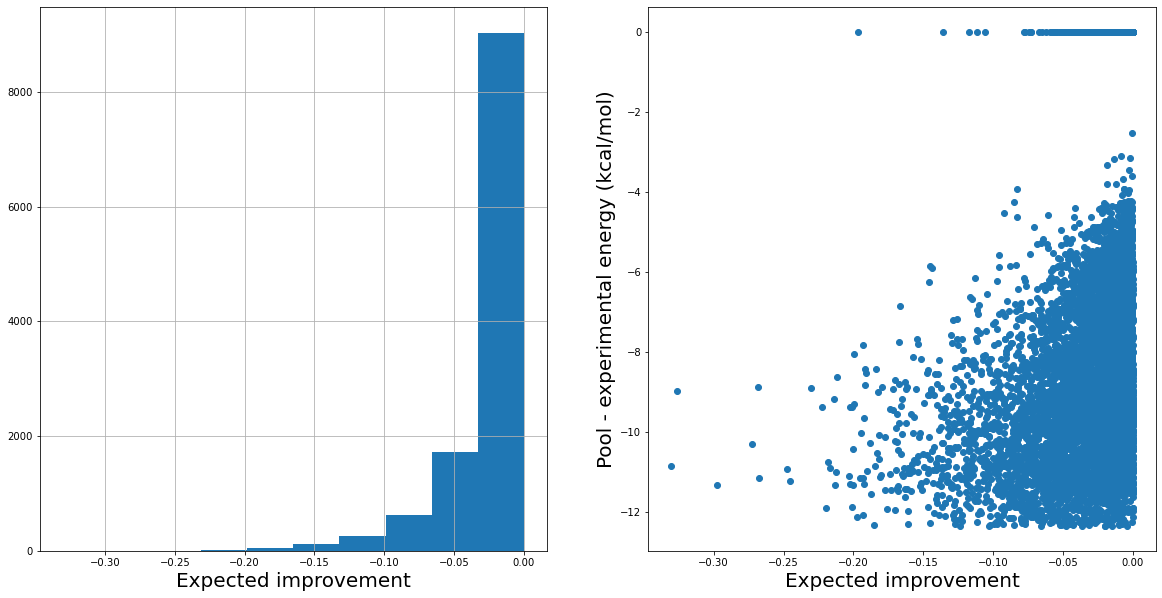

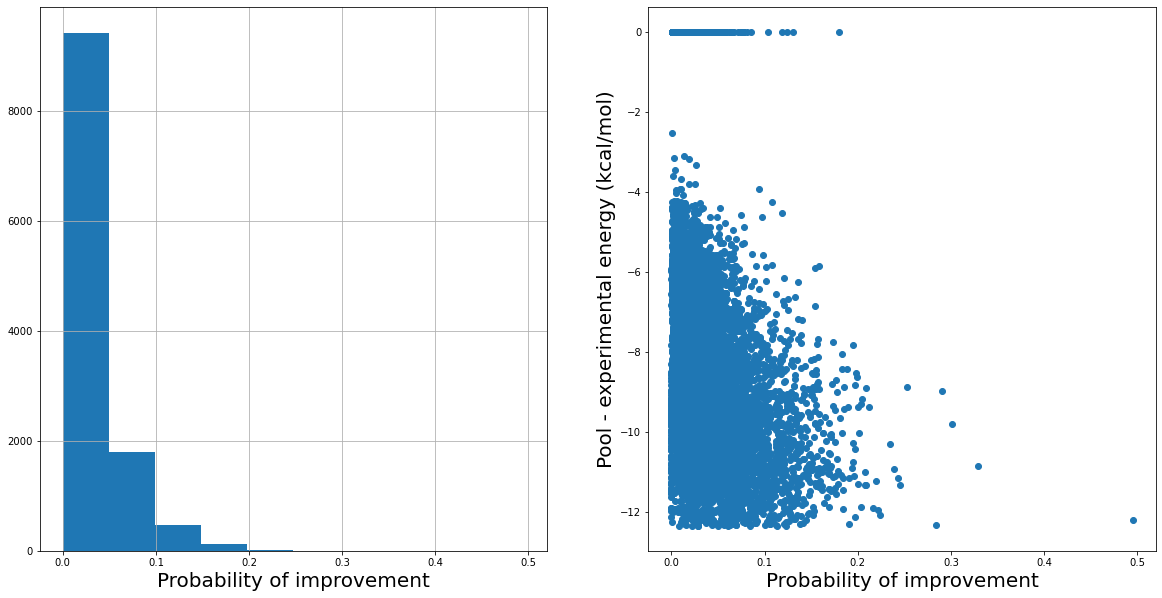

In [280]:
# Show the Expected improvement and Probability of improvement for the initial model

model = get_fitted_model(X_fps[train_ids], y[train_ids])

for ac_fun in ['EI', 'PI']:
    fig, axarr = plt.subplots(1, 2, figsize=(20, 10))
    
    if ac_fun == 'EI':
        p = expected_improvement(model, y[train_ids], X_fps[pool_ids])

        pd.Series(p).hist(ax=axarr[0])
        axarr[0].set_xlabel('Expected improvement', fontsize=20)

        axarr[1].scatter(p, y[pool_ids])
        axarr[1].set_xlabel('Expected improvement', fontsize=20)
    else:
        p = probability_of_improvement(model, y[train_ids], X_fps[pool_ids])

        pd.Series(p).hist(ax=axarr[0])
        axarr[0].set_xlabel('Probability of improvement', fontsize=20)

        axarr[1].scatter(p, y[pool_ids])
        axarr[1].set_xlabel('Probability of improvement', fontsize=20)
    
    axarr[1].set_ylabel('Pool - experimental energy (kcal/mol)', fontsize=20)
    
    plt.show()

Init.
Train:  150
Pool :  11820
Best peptide: -12.197
N pep under -12 kcal/mol: 002
N pep under -11 kcal/mol: 018
N pep under -10 kcal/mol: 043
N pep under -9 kcal/mol: 083
Decoy pep               : 000



1


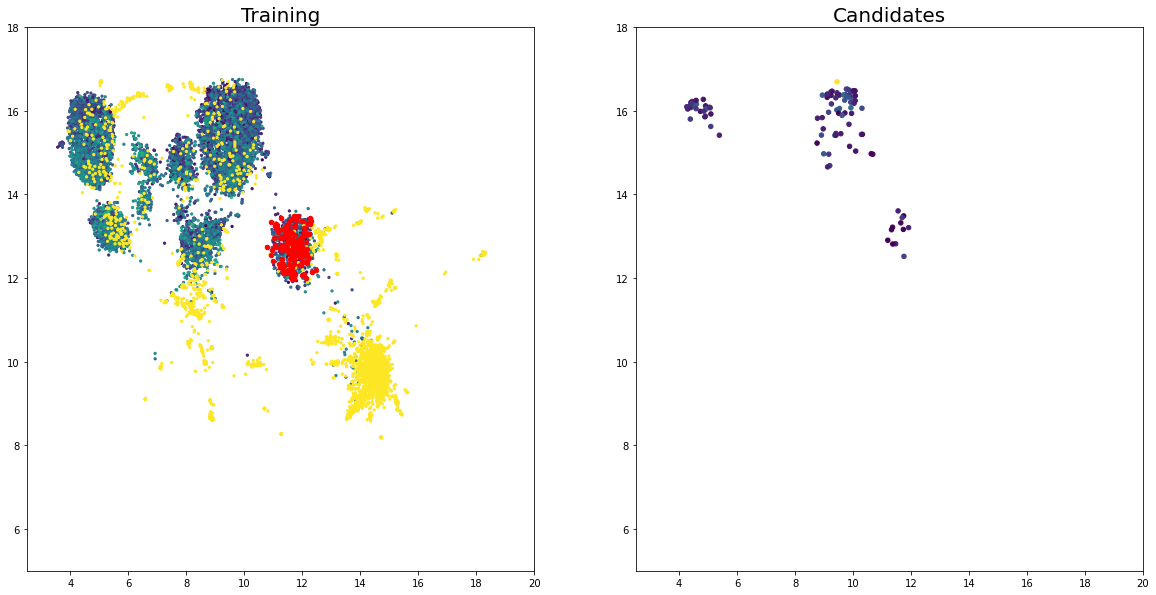

Train:  246
Pool :  11724
Best peptide: -12.308
N pep under -12 kcal/mol: 007 (7.292)
N pep under -11 kcal/mol: 055 (57.292)
N pep under -10 kcal/mol: 111 (115.625)
N pep under -9 kcal/mol: 164 (170.833)
Decoy pep               : 001



2


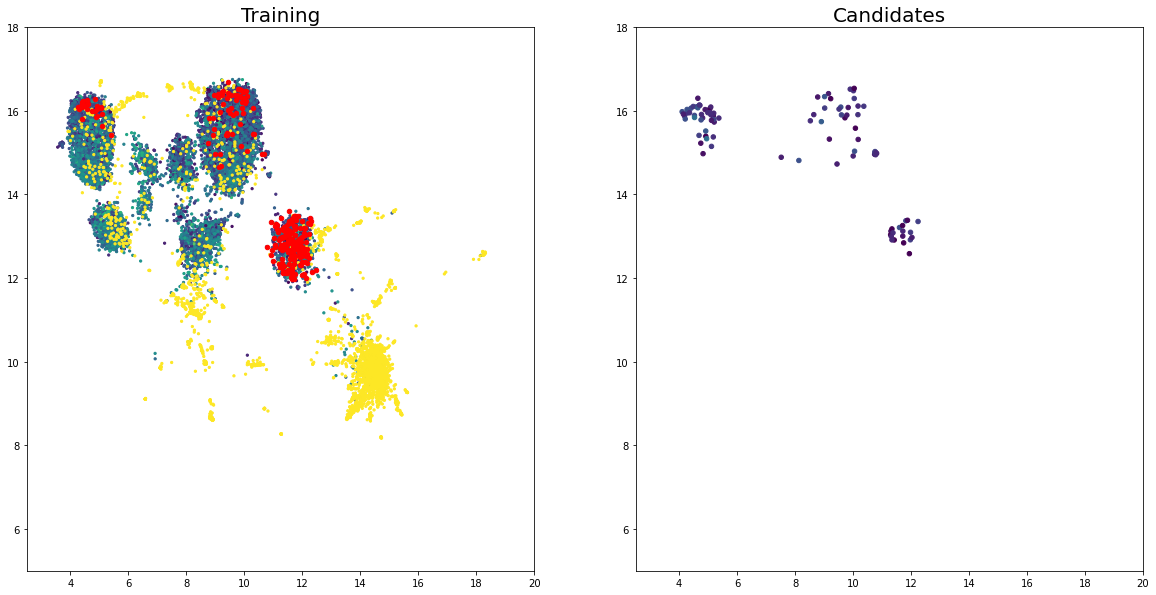

Train:  342
Pool :  11628
Best peptide: -12.341
N pep under -12 kcal/mol: 017 (8.854)
N pep under -11 kcal/mol: 088 (45.833)
N pep under -10 kcal/mol: 179 (93.229)
N pep under -9 kcal/mol: 253 (131.771)
Decoy pep               : 001



3


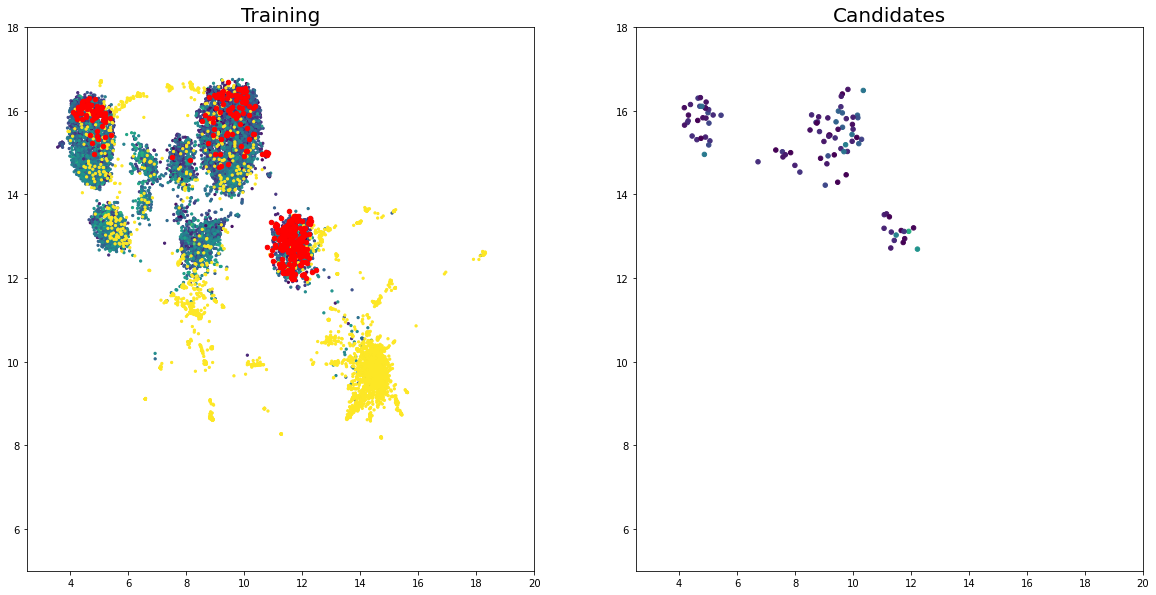

Train:  438
Pool :  11532
Best peptide: -12.341
N pep under -12 kcal/mol: 029 (10.069)
N pep under -11 kcal/mol: 129 (44.792)
N pep under -10 kcal/mol: 249 (86.458)
N pep under -9 kcal/mol: 333 (115.625)
Decoy pep               : 001





In [281]:
n_pep = 96
acq_function = 'PI'

print('Init.')
print('Train: ', X_fps[train_ids].shape[0])
print('Pool : ', X_fps[pool_ids].shape[0])
print('Best peptide: %.3f' % y[train_ids].min())
for n in [-12, -11, -10, -9]:
    print('N pep under %d kcal/mol: %03d' % (n, y[train_ids][y[train_ids] < n].shape[0]))
print('Decoy pep               : %03d' % (y[train_ids][y[train_ids] == 0.].shape[0]))
    
print('\n\n')

for i in range(3):
    print(i + 1)
    model = get_fitted_model(X_fps[train_ids], y[train_ids])
    
    if acq_function == 'EI':
        p = expected_improvement(model, y[train_ids], X_fps[pool_ids], xi=0)
        indices = np.argsort(p)
    else:
        p = probability_of_improvement(model, y[train_ids], X_fps[pool_ids])
        indices = np.argsort(p)[::-1]
    
    # Select candidates
    candidates_ids = pool_ids[indices[:n_pep]]
    
    fig, axarr = plt.subplots(1, 2, figsize=(20, 10))
    axarr[0].scatter(u[:,0], u[:,1], s=5, c=y.numpy(), vmin=-12, vmax=0)
    axarr[0].scatter(u[:,0][train_ids], u[:,1][train_ids], s=20, c='red')
    axarr[1].scatter(u[:,0][candidates_ids], u[:,1][candidates_ids], s=20, c=y.numpy()[candidates_ids], vmin=-12, vmax=0)
    
    axarr[0].set_title('Training', fontsize=20)
    axarr[1].set_title('Candidates', fontsize=20)
    axarr[0].set_xlim([2.5, 20])
    axarr[0].set_ylim([5, 18])
    axarr[1].set_xlim([2.5, 20])
    axarr[1].set_ylim([5, 18])
    
    plt.show()
    
    # Add candidates to train dataset
    train_ids = np.hstack([train_ids, candidates_ids])
    print('Train: ', train_ids.shape[0])
    
    # Remove candidates from pool
    pool_ids = pool_ids[~np.in1d(pool_ids, candidates_ids)]
    print('Pool : ', pool_ids.shape[0])
    print('Best peptide: %.3f' % y[train_ids].min())
    
    for n in [-12, -11, -10, -9]:
        x = y[train_ids][y[train_ids] < n].shape[0]
        print('N pep under %d kcal/mol: %03d (%.3f)' % (n, x, x / (n_pep * (i + 1)) * 100.))
    print('Decoy pep               : %03d' % (y[train_ids][y[train_ids] == 0.].shape[0]))
    
    print('\n\n')